<a href="https://colab.research.google.com/github/charanj15076/NLP_tribrid_embed/blob/main/tribrid_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Access To Gpu
!nvidia-smi


Sat Jan 13 20:07:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#Replicationg paper PubMed 200k RCT
## Get data freely from : https://github.com/Franck-Dernoncourt/pubmed-rct
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#experimenting woth 20K samples first with numbers replaced with @
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [5]:
import os
filenames = [ data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
##preprocessing our data
def get_lines(filename):
  """
  Reads filename a text filename and returns the lines of text  as a list.

  Args:
    filename : a string containing  the target filepath.

  Returns:
    A list  of strings  with one string per line form the filename specified.
  """
  with open(filename , "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
# writing our own preprocessing function
def preprocess(filename):
  """
    takes in filename and returns as dictionary with target name and line number and number of lines

  """
  input_lines = get_lines(filename)
  abstract_data = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_data = ""
      abstract_id = line
    elif line.isspace():
      abstract_data_split = abstract_data.splitlines()
      for abstract_line_number , abstract_line in enumerate(abstract_data_split):
        lines_data = {}
        lines_split_data = abstract_line.split("\t")
        lines_data["target"] = lines_split_data[0]
        lines_data["text"] = lines_split_data[1].lower()
        lines_data["line_number"] = abstract_line_number
        lines_data["total_lines"] = len(abstract_data_split)-1
        abstract_samples.append(lines_data)
    else:
      abstract_data += line
  return abstract_samples


In [10]:
%%time
train_samples = preprocess(data_dir +"train.txt")
val_samples = preprocess(data_dir +"dev.txt")
test_samples = preprocess(data_dir +"test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 759 ms, sys: 121 ms, total: 880 ms
Wall time: 1.24 s


In [11]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df[:14]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

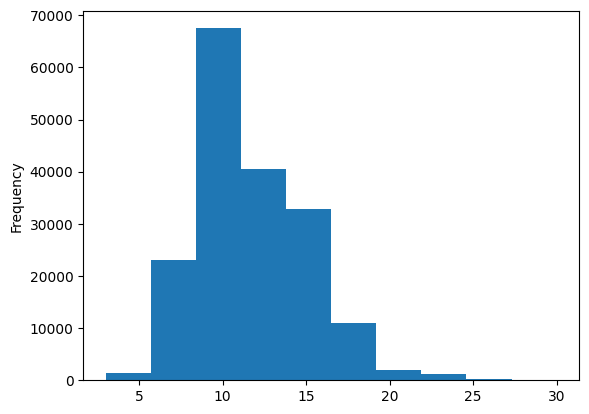

In [14]:
train_df.total_lines.plot.hist()


In [15]:
#get data into list
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
print(len(train_sentences),len(val_sentences),len(test_sentences))

180040 30212 30135


In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [17]:
# turing targets in to labels
from sklearn.preprocessing import OneHotEncoder
onehotencder = OneHotEncoder(sparse = False)
train_labels_one_hot = onehotencder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = onehotencder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = onehotencder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
from re import L
#type 2 label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_target_labels_label_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_target_labels_label_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_target_labels_label_encoded = label_encoder.transform(test_df["target"].to_numpy())


train_target_labels_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
#model_0 baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])


model_0.fit(X = train_sentences,
          y = train_target_labels_label_encoded);

In [21]:

# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:

# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import calculate_results helper function
from helper_functions import calculate_results

--2024-01-13 20:08:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-13 20:08:28 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:

# Calculate baseline results
baseline_results = calculate_results(y_true=val_target_labels_label_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [24]:
##preparing train data for deep models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [25]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

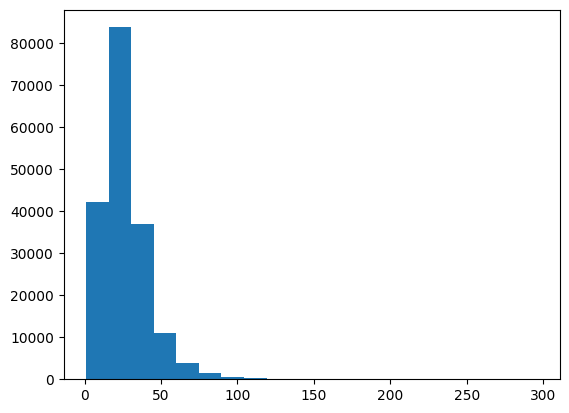

In [26]:
import  matplotlib.pyplot as plt
plt.hist(sent_lens,bins = 20)

In [27]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [28]:
max_tokens = 68000

In [29]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                     output_sequence_length = 55)

In [30]:
# adapt our text vectorizer to our training set
text_vectorizer.adapt(train_sentences)

In [31]:

# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [32]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embediing")


In [33]:
#making our data load as ffast as possible with tf.data api
# train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
# val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [34]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [35]:
#now we prefetch our data for faster loading in batches prefetch in cpu an dgpu loads the next batch quickly
# train_dataset  = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [36]:
# #conv1d with token embeddings
# inputs = layers.Input(shape=(1,),dtype = tf.string)
# token_vectors = text_vectorizer(inputs)
# embeds = token_embed(token_vectors)
# x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(embeds)
# x = layers.GlobalAvgPool1D()(x)
# outputs = layers.Dense(num_classes,activation = "softmax")(x)
# model_1 = tf.keras.Model(inputs,outputs)

# #compile
# model_1.compile(loss = "binary_crossentropy",
#                 optimizer = tf.optimizers.Adam(),
#                 metrics = ["accuracy"])


# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embediing (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [38]:
# model_1_history = model_1.fit(train_dataset,
#                               steps_per_epoch = int(0.1*len(train_dataset)),
#                               epochs = 3,
#                               validation_data = val_dataset,
#                               validation_steps = int(0.1*len(val_dataset))
#                               )



# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches


Epoch 1/3
562/562 [==============================] - 23s 32ms/step - loss: 0.9152 - accuracy: 0.6385 - val_loss: 0.6889 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 6s 12ms/step - loss: 0.6629 - accuracy: 0.7553 - val_loss: 0.6322 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6219 - accuracy: 0.7728 - val_loss: 0.6002 - val_accuracy: 0.7852


In [39]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6022 - accuracy: 0.7841


[0.6022463440895081, 0.7841255068778992]

In [40]:
model_1_probs = model_1.predict(valid_dataset)
model_1_probs[:10]

945/945 [==============================] - 2s 2ms/step


array([[4.3241465e-01, 1.7853782e-01, 7.2186403e-02, 2.9529023e-01,
        2.1570886e-02],
       [4.3926296e-01, 2.7855077e-01, 1.4383186e-02, 2.5913563e-01,
        8.6675845e-03],
       [1.3379094e-01, 9.2466418e-03, 2.0046635e-03, 8.5493362e-01,
        2.4089961e-05],
       [1.6277634e-05, 2.6428275e-04, 9.8077148e-01, 1.4441828e-05,
        1.8933473e-02],
       [1.3409009e-03, 2.8664395e-02, 3.4551138e-01, 9.6443045e-04,
        6.2351888e-01],
       [2.3300853e-02, 3.0682111e-02, 5.5859578e-01, 9.9559333e-03,
        3.7746537e-01],
       [6.2099856e-04, 4.8905746e-03, 2.5367540e-01, 2.5982119e-04,
        7.4055326e-01],
       [3.7772305e-02, 3.3900227e-02, 6.1862528e-01, 1.6885083e-02,
        2.9281715e-01],
       [5.7841422e-13, 6.2133111e-08, 1.9362633e-07, 3.2732714e-13,
        9.9999976e-01],
       [1.0572862e-02, 6.3188654e-01, 4.2522941e-02, 2.4276419e-02,
        2.9074121e-01]], dtype=float32)

In [41]:
model_1_preds = tf.argmax(model_1_probs,axis =1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [42]:
model_1_results = calculate_results(val_target_labels_label_encoded,model_1_preds)
model_1_results

{'accuracy': 78.41255130411757,
 'precision': 0.7804571988756438,
 'recall': 0.7841255130411757,
 'f1': 0.7813626477223847}

In [43]:
#model_2 feature extraction with pretrained model embeddding
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [44]:
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embed = tf_hub_embedding_layer(inputs) #this tokenizes the text and creates embedding of 512 lenght
x = layers.Dense(128,activation = "relu")(pretrained_embed)
outputs  = layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs,outputs, name = "model_2_con1d_pretrained_embeddings")

model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.optimizers.Adam(),
                metrics = ["accuracy"])




In [45]:
model_2.summary()

Model: "model_2_con1d_pretrained_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [46]:
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 15ms/step - loss: 0.3415 - accuracy: 0.6251 - val_loss: 0.2853 - val_accuracy: 0.6855
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.2736 - accuracy: 0.6943 - val_loss: 0.2681 - val_accuracy: 0.6995
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.2650 - accuracy: 0.7076 - val_loss: 0.2607 - val_accuracy: 0.7114


In [47]:
model_2_probs = model_2.predict(valid_dataset)
model_2_probs[:10]

945/945 [==============================] - 11s 11ms/step


array([[4.5208198e-01, 3.8977784e-01, 1.4163965e-03, 1.5004684e-01,
        6.6769528e-03],
       [2.8096655e-01, 6.2477648e-01, 1.3361946e-03, 9.1362685e-02,
        1.5581177e-03],
       [1.7382765e-01, 1.5126419e-01, 1.4620229e-02, 6.2427735e-01,
        3.6010534e-02],
       [3.5219456e-03, 1.1967480e-02, 9.5600247e-01, 2.4584553e-03,
        2.6049618e-02],
       [1.6928487e-02, 1.4516118e-01, 2.3070379e-01, 1.0215192e-02,
        5.9699130e-01],
       [3.5213368e-04, 6.1954971e-04, 9.1162151e-01, 5.3661421e-05,
        8.7353140e-02],
       [1.0048040e-03, 1.2617521e-03, 8.3740664e-01, 9.0724637e-04,
        1.5941960e-01],
       [3.2930179e-03, 1.6035574e-02, 4.4397709e-01, 9.2822732e-04,
        5.3576607e-01],
       [8.0313563e-05, 5.3781929e-04, 1.5460794e-03, 2.4280924e-04,
        9.9759299e-01],
       [7.3290966e-02, 8.2128835e-01, 1.3304300e-02, 5.5248555e-02,
        3.6867864e-02]], dtype=float32)

In [48]:
model_2_preds = tf.argmax(model_2_probs,axis = 1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 4, 4, 1])>

In [49]:
model_2_results = calculate_results(val_target_labels_label_encoded,model_2_preds)
model_2_results

{'accuracy': 71.31934330729511,
 'precision': 0.7116970893191915,
 'recall': 0.7131934330729511,
 'f1': 0.7084923991164468}

In [50]:
#model_1 with characted embeddings
# one character at a time rather than a word as we used previously
def split_chars(text):
  return " ".join(list(text))

In [51]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [52]:
char_length = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_length)
mean_char_lens

149.3662574983337

In [53]:
output_seq_char_len = int(np.percentile(char_length,95))
output_seq_char_len

290

In [54]:
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits

In [55]:
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [56]:
num_char_tokens = len(alphabet)+2
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length  = output_seq_char_len,
                                    name = "char_emeddings")

In [57]:
char_vectorizer.adapt(train_chars)

In [58]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab : {len(char_vocab)}")

Number of different characters in character vocab : 28


In [59]:
char_embed = layers.Embedding(input_dim  = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embedding")

In [60]:
# make cov1d in charcter level embedding
inputs  = layers.Input(shape = (1,),dtype = "string")
char_tokens = char_vectorizer(inputs)
char_embeddings = char_embed(char_tokens)
x = layers.Conv1D(64, kernel_size = 5, padding = "same",activation = "relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs,outputs, name = "model_3_char_embeds_conv1d")

model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.optimizers.Adam(),
                metrics = ["accuracy"])




In [61]:

model_3.summary()

Model: "model_3_char_embeds_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_emeddings (TextVector  (None, 290)               0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)  

In [62]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))

train_chars_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
testchars_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
model_3_histpry = model_3.fit(train_chars_dataset,
                              steps_per_epoch = int(0.1*len(train_chars_dataset)),
                              epochs = 3,
                              validation_data = val_chars_dataset,
                              validation_steps = int(0.1*len(val_chars_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 0.4320 - accuracy: 0.4567 - val_loss: 0.3683 - val_accuracy: 0.5485
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.3520 - accuracy: 0.5780 - val_loss: 0.3352 - val_accuracy: 0.6014
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.3276 - accuracy: 0.6201 - val_loss: 0.3142 - val_accuracy: 0.6443


In [64]:
model_3_probs = model_3.predict(val_chars_dataset)
model_3_probs[:10]

945/945 [==============================] - 4s 4ms/step


array([[1.34264946e-01, 3.26761663e-01, 3.23353052e-01, 1.97795212e-01,
        1.78251732e-02],
       [1.36900559e-01, 4.56959963e-01, 5.16796811e-03, 3.90320510e-01,
        1.06509076e-02],
       [1.30598441e-01, 2.82864869e-01, 6.22259490e-02, 5.06770372e-01,
        1.75403953e-02],
       [2.92633194e-03, 9.32741724e-03, 9.58994210e-01, 6.48079580e-03,
        2.22713389e-02],
       [1.53321605e-02, 3.05367000e-02, 8.27907443e-01, 2.44029034e-02,
        1.01820782e-01],
       [2.48870521e-04, 6.07914641e-04, 9.74242628e-01, 2.24669231e-04,
        2.46759802e-02],
       [3.37922480e-03, 3.73616326e-03, 8.67830396e-01, 1.88812835e-03,
        1.23166092e-01],
       [2.48348713e-01, 2.11955145e-01, 8.14571381e-02, 1.49977624e-01,
        3.08261395e-01],
       [1.29751791e-03, 3.43791652e-03, 2.03024615e-02, 1.13329641e-03,
        9.73828793e-01],
       [5.10613844e-02, 2.16353193e-01, 3.19249779e-01, 1.64598882e-01,
        2.48736799e-01]], dtype=float32)

In [65]:
model_3_preds = tf.argmax(model_3_probs,axis = 1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 2, 2, 2, 2, 4, 4, 2])>

In [66]:
model_3_results = calculate_results(val_target_labels_label_encoded,model_3_preds)
model_3_results

{'accuracy': 64.51410035747385,
 'precision': 0.6399778434124109,
 'recall': 0.6451410035747385,
 'f1': 0.6310742387468642}

In [67]:
#model_4 combining character embeddings and token emebeddings and creating an ensemble(hybrid embedding layer)
# step1 create a token embedding input/ model
import tensorflow_hub as hub
pretrained_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name = "universal_sentence_encoder_layer")
token_inputs = layers.Input(shape= [], dtype = tf.string)
token_embedding_layer =  pretrained_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embedding_layer)
token_model =  tf.keras.Model(inputs = token_inputs,outputs = token_outputs)


#step2 create character emebedding input/model
character_tokens = layers.Input(shape= (1,),dtype = tf.string)
character_tokenizer = char_vectorizer(character_tokens)
character_embeddings = char_embed(character_tokenizer)
char_bi_dir_lstm = layers.Bidirectional(layers.LSTM(25))(character_embeddings)
char_model = tf.keras.Model(inputs = character_tokens,outputs = char_bi_dir_lstm)

#step 3 combine 1 and 2 with tf.concatenate (hybrid token embedding)
token_char_concat = layers.Concatenate(name= "token_char_hybrid")([token_model.output,
                                                                   char_model.output
                                                                   ])


#step 4 create output layers and add dropout layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combine_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combine_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],
                         outputs = output_layer,
                         name = "hybrid_model")




In [68]:
#summary
model_4.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_emeddings (TextVector  (None, 290)                  0         ['input_5[0][0]']             
 ization)                                                                                         
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_4[0][0]']  

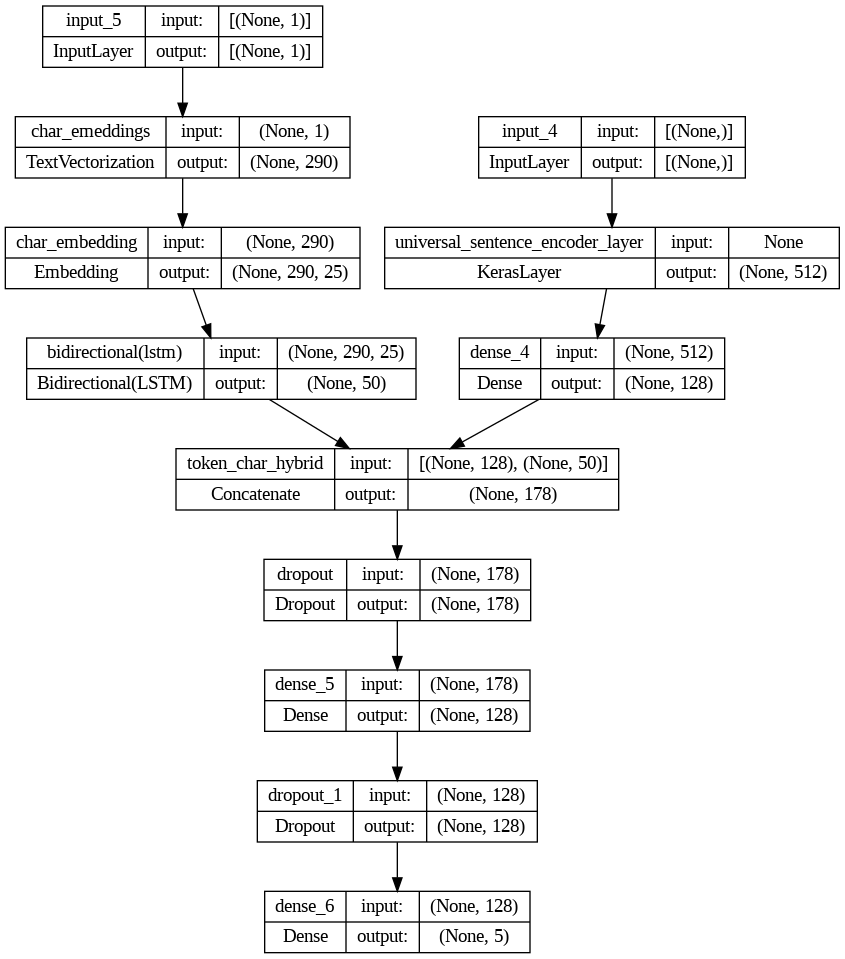

In [69]:
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)


In [70]:
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.optimizers.Adam(),
                metrics = ["accuracy"])

In [71]:
#efficient data input pipeline
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

#prefetch train data

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [72]:
#efficient data input pipeline
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

#prefetch train data

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
##fitting our model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 45s 56ms/step - loss: 0.3486 - accuracy: 0.5897 - val_loss: 0.2731 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.2776 - accuracy: 0.6924 - val_loss: 0.2521 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.2677 - accuracy: 0.7055 - val_loss: 0.2452 - val_accuracy: 0.7284


In [74]:
model_4_probs = model_4.predict(val_char_token_dataset)
model_4_probs[:10]

945/945 [==============================] - 23s 21ms/step


array([[5.08503020e-01, 3.73951226e-01, 1.52086362e-03, 1.13469034e-01,
        2.55584251e-03],
       [3.37285101e-01, 5.55287123e-01, 8.81817774e-04, 1.05487429e-01,
        1.05854706e-03],
       [3.06036115e-01, 1.53367311e-01, 3.56845893e-02, 4.70702320e-01,
        3.42097208e-02],
       [5.09617617e-03, 7.66403880e-03, 9.37634289e-01, 3.20152962e-03,
        4.64039780e-02],
       [2.19834708e-02, 8.54684711e-02, 6.77509367e-01, 9.92216356e-03,
        2.05116495e-01],
       [2.95625301e-04, 6.46257948e-04, 8.27744842e-01, 1.32230984e-04,
        1.71181038e-01],
       [2.07232870e-03, 6.78739790e-03, 6.00491762e-01, 9.51191119e-04,
        3.89697284e-01],
       [1.21215091e-03, 9.97678377e-03, 4.80085701e-01, 4.22989251e-04,
        5.08302391e-01],
       [2.56235562e-05, 6.02616055e-04, 1.09052262e-03, 1.05743038e-05,
        9.98270631e-01],
       [1.49066001e-01, 7.21365154e-01, 2.16358472e-02, 6.07038327e-02,
        4.72291894e-02]], dtype=float32)

In [75]:
model_4_preds = tf.argmax(model_4_probs,axis = 1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 4, 4, 1])>

In [76]:
model_4_results = calculate_results(val_target_labels_label_encoded,model_4_preds)
model_4_results

{'accuracy': 73.0405137031643,
 'precision': 0.7306350494950824,
 'recall': 0.730405137031643,
 'f1': 0.7265980169187305}

In [77]:
#model5 : transfer learning with char embeddings, token embeddings and positional embeddings
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

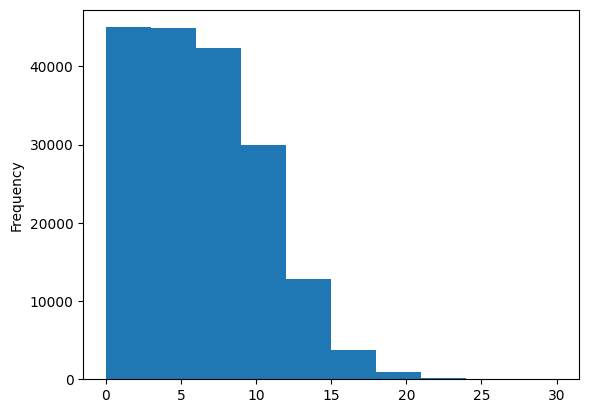

In [78]:
train_df.line_number.plot.hist()

<Axes: ylabel='Frequency'>

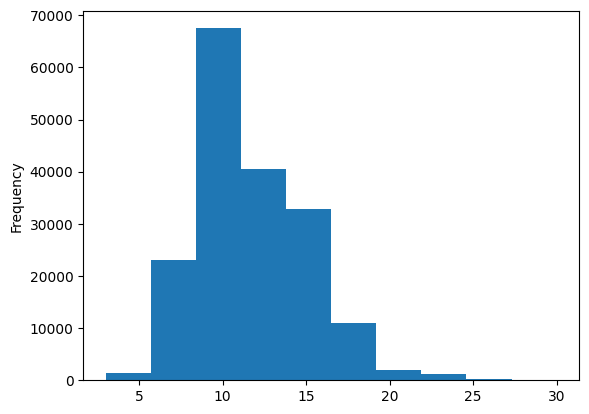

In [82]:
train_df.total_lines.plot.hist()

In [85]:
train_lines_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_lines_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_lines_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_lines_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [87]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth = 20)
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [93]:
# building hybrid embedding model
import tensorflow_hub as hub
pretrained_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable = False, name = "universal_sentence_encoder")

token_inputs = layers.Input(shape = [],dtype = tf.string , name = "token_inputs")
universal_encoder = pretrained_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(universal_encoder)
token_model = tf.keras.Model(inputs = token_inputs,outputs = token_outputs)

#char inputs
char_inputs = layers.Input(shape=(1,), dtype = tf.string , name = "char_inputs")
char_tokens = char_vectorizer(char_inputs)
char_embeddings  = char_embed(char_tokens)
char_bi_dir_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_dir_lstm)

#line_numbers inputs
line_number_inputs = layers.Input(shape= (15,), dtype = tf.float32, name = "line_number_inputs")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs, outputs = x)

#total_line numbers inputs
total_line_numbers_input = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
y = layers.Dense(32,activation = "relu")(total_line_numbers_input)
total_lines_model = tf.keras.Model(inputs = total_line_numbers_input, outputs = y)

#combine token and char embeddings

combined_embeddings = layers.Concatenate(name = "char_token_emebeddings")([token_model.output,
                                                                           char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#combine positional embeddings with combined char and token embeddings
tribrid_embeddings = layers.Concatenate(name = "lines_total_lines_char_token_embeddings")([line_number_model.output,
                                                                                           total_lines_model.output,
                                                                                           z])
# create output layer
output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_embeddings)

#build model
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "multi_embedding_model")







In [94]:
model_5.summary()

Model: "multi_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_emeddings (TextVector  (None, 290)                  0         ['char_inputs[0][0]']         
 ization)                                                                                         
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_in

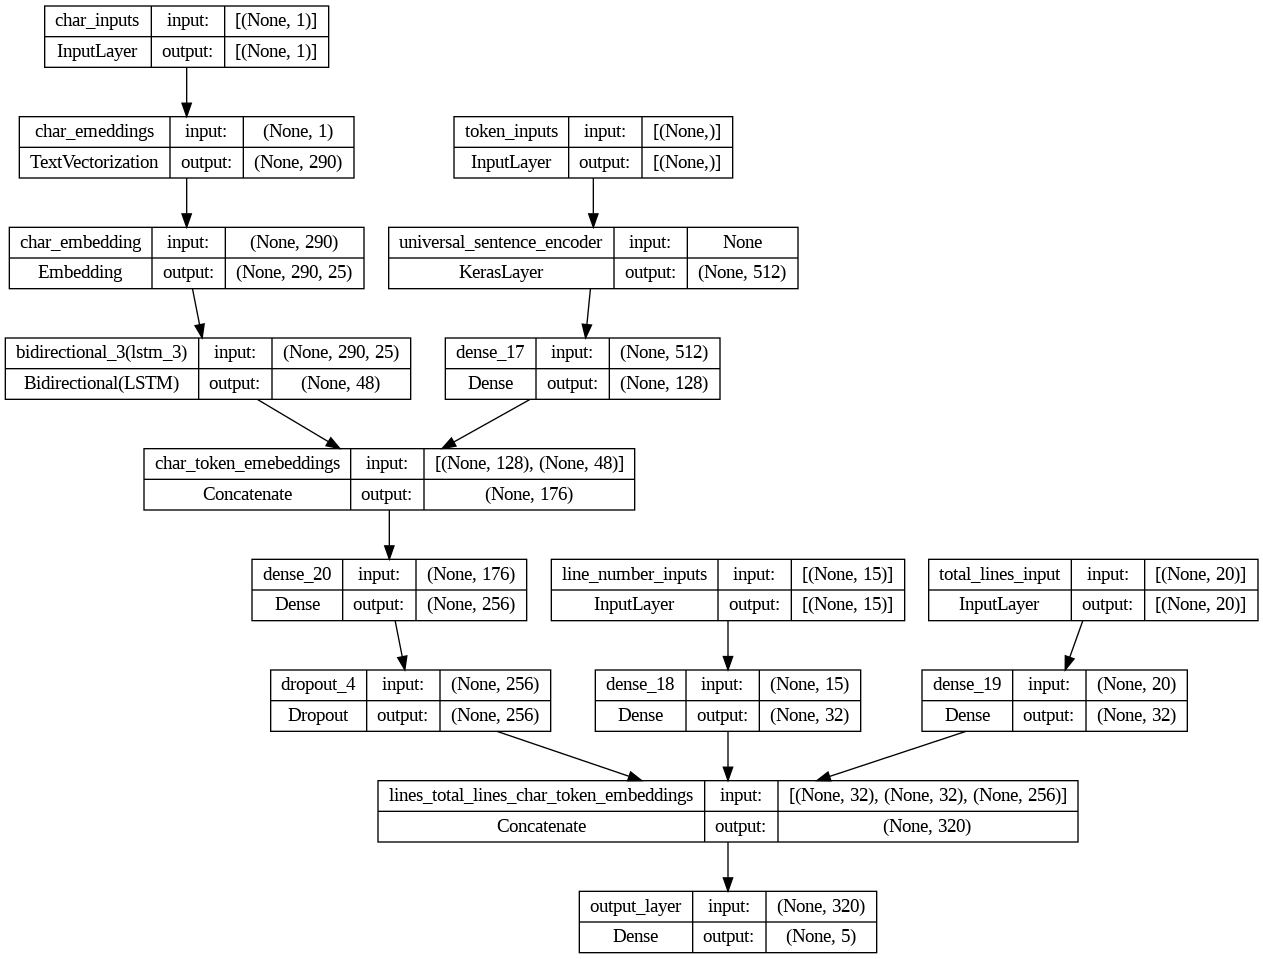

In [97]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True)

In [100]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), #helps to prevent over fitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [102]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_lines_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_lines_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_lines_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [103]:
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [104]:
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))


Epoch 1/3
562/562 [==============================] - 50s 66ms/step - loss: 1.1001 - accuracy: 0.7189 - val_loss: 0.9835 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 43s 77ms/step - loss: 0.9670 - accuracy: 0.8151 - val_loss: 0.9486 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 26s 45ms/step - loss: 0.9495 - accuracy: 0.8221 - val_loss: 0.9381 - val_accuracy: 0.8318


In [105]:
model_5_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_probs, axis = 1)
model_5_results = calculate_results(val_target_labels_label_encoded, model_5_preds)
model_5_results

945/945 [==============================] - 24s 21ms/step


{'accuracy': 83.32119687541373,
 'precision': 0.8319301615428515,
 'recall': 0.8332119687541374,
 'f1': 0.8319549316114628}

In [106]:
# compare results of each model
import pandas as pd
all_model_results = pd.DataFrame({"model_0_baseline_model" :  baseline_results,
                                  "model_1_custom_token_embedding" : model_1_results,
                                  "model_2_pretrained_token_embed" : model_2_results,
                                  "model_3_custom_char_embed" :  model_3_results,
                                  "model_4_hybrid_emebed" :  model_4_results,
                                  "model_4_tribrid_emebed": model_5_results})

In [109]:
all_model_results.transpose()

,accuracy,precision,recall,f1
model_0_baseline_model,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.412551,0.780457,0.784126,0.781363
model_2_pretrained_token_embed,71.319343,0.711697,0.713193,0.708492
model_3_custom_char_embed,64.514100,0.639978,0.645141,0.631074
model_4_hybrid_emebed,73.040514,0.730635,0.730405,0.726598
model_4_tribrid_emebed,83.321197,0.831930,0.833212,0.831955


In [110]:
#saving model
model_5.save("tribrid_emebed_model")

In [111]:
#loading saved model
loaded_model = tf.keras.models.load_model("tribrid_emebed_model")